In [20]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
"""Data preprocessing for HCMC survey dataset"""

__author__ = "Anna Buch, Heidelberg University"
__email__ = "a.buch@stud.uni-heidelberg.de"

## Feature selection 
Enitre workflow with all models for the target variables relative content loss and business reduction (degree of loss) as well for the binary version of relative content loss (chance of loss)

Due to the samll sample size a nested CV is used to have the possibility to even get generalization error, in the inner CV the best hyperaparamters based on k-fold are selected; in the outer cv the generalization error across all tested models is evaluated. A seprate unseen validation set as done by train-test split would have an insufficent small sample size.
Nested CV is computationally intensive but with the samll sample size and a well chosen set of only most important hyperparameters this can be overcome.

- Logistic Regression (binrary rcloss)
- Elastic Net
- eXtreme Gradient Boosting
- Conditional Random Forest


In [21]:
import os, sys
from pathlib import Path
import json

import joblib


## TODO move to utils
def load_config(config_file):
    """
    Load config file
    :param config_file: path to config file (str)
    :return:
    """
    assert os.path.exists(
        config_file
    ), f"Configuration file does not exist: {os.path.abspath(config_file)}"
    with open(config_file, "r") as src:
        config = json.load(src)
    return config


In [22]:
import os, sys
from pathlib import Path
import json
import copy as cp
from glob import glob
import numpy as np
import pandas as pd


import pickle
import joblib

from xgboost import XGBRegressor, XGBRFRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, RepeatedStratifiedKFold, RepeatedKFold, cross_val_score, KFold, cross_validate
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error, PredictionErrorDisplay,  f1_score, confusion_matrix, mean_absolute_error

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns


#os.chdir(sys.path[0])
sys.path.insert(0, "../../../")
import utils.utils_feature_selection as fs
import utils.utils_evaluation as e
import utils.utils_figures as f
import utils.settings as s
import utils.pipelines as p

p.main()  # create/update model settings
#s.init()
seed = s.seed

pd.set_option('display.max_columns', None)
plt.figure(figsize=(20, 10))

import warnings
warnings.filterwarnings('ignore')

targets = ["Target_relative_contentloss_euro", "Target_businessreduction"]
target = targets[0]


<Figure size 2000x1000 with 0 Axes>

#### Load R packages to process Conditional Random Forest in python
*Note 1: all needed R packages have to be previously loaded in R*

*Note 2: Make sure that caret package version >= 6.0-81, otherwise caret.train() throws an error*

In [23]:
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr, data
import rpy2.robjects.packages as rpackages


# get basic R packages
utils = importr('utils')
base = importr('base')
dplyr = importr('dplyr')
stats_r = importr("stats")  # rename due to similar python package

# pandas.DataFrames to R dataframes 
from rpy2.robjects import pandas2ri, Formula
pandas2ri.activate()

# print r df in html
import rpy2.ipython.html
rpy2.ipython.html.init_printing()


# get libraries for CRF processing, ctree_controls etc
partykit = importr('partykit')
party = importr('party')
caret = importr('caret') # package version >=
#stablelearner = importr('stablelearner')
ggplot2 = importr('ggplot2')


In [24]:
df_candidates = pd.read_excel("../../../input_survey_data/input_data_contentloss_tueb.xlsx")
#df_candidates = pd.read_excel("../../../input_survey_data/input_data_businessreduction_tueb.xlsx")


In [25]:
### TODO impl this cell in data_cleaning

df_candidates = df_candidates.drop(["Target_contentloss_euro", "shp_content_value_euro"], axis=1)
#df_candidates = df_candidates.drop(["Target_relative_contentloss_euro"], axis=1)

try:
    #if target=="Target_relative_contentloss_euro": 
    df_candidates = df_candidates.drop("floors", axis=1 )  # remove if still in ds due that it's used for shp_content_value and relative content loss
    df_candidates = df_candidates.drop("buildingtype_moon", axis=1)  # remove due to 64 % missing values   
except:
    pass
try:
    df_candidates = df_candidates.drop("elevation_building_height_cm", axis=1)
    df_candidates = df_candidates.drop(["contaminations_light","contaminations_heavy"], axis=1)
    df_candidates = df_candidates.drop("resilience_govern_careing_increases", axis=1)
except:
    pass


df_candidates.shape

(397, 28)

In [26]:
df_candidates

,Target_relative_contentloss_euro,inundation_duration_h,water_depth_cm,contaminations.0,flowvelocity,emergency_measures.1,emergency_measures.2,emergency_measures.3,emergency_measures.4,emergency_measures.7,emergency_measures.8,overall_problem_house,protect_valuables_impl,water_barriers_impl,pumping_equipment_impl,elevation_building_impl,resistant_material_building_impl,electricity_higher_impl,flood_protections_impl,flood_experience,bage,b_area,hh_monthly_income_cat,shp_owner,shp_sector,shp_employees,shp_avgmonthly_sale_cat,shp_registered_capital_euro
0,0.0,2.0,10.0,1,2,0,0,0,0,0,0,1,5,5,5,4,5,5,5,5,12.0,25.0,2.0,3,17,1,2,184.1
1,0.0,2.0,15.0,0,2,0,0,0,0,0,0,1,5,5,5,4,5,5,5,5,0.0,21.0,3.0,3,22,1,2,368.3
2,0.0,1.0,2.0,1,2,0,0,0,0,0,0,1,1,5,1,1,5,1,5,5,21.0,50.0,4.0,1,31,1,1,368.3
3,0.0,3.0,10.0,1,1,0,0,0,0,0,0,1,1,1,5,5,5,1,5,3,20.0,25.0,2.0,1,11,1,1,NaN
4,0.0,3.0,5.0,0,3,0,0,0,0,0,0,1,5,5,5,1,5,1,5,3,20.0,80.0,3.0,1,11,1,1,36.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
392,0.0,5.0,40.0,0,2,0,1,1,1,1,0,1,1,1,5,4,5,5,5,6,1.0,80.0,3.0,3,11,2,2,3682.6
393,0.0,4.0,60.0,0,3,1,1,1,1,1,0,1,2,1,1,2,5,1,5,6,30.0,60.0,4.0,1,11,2,3,3682.6
394,NaN,5.0,70.0,0,1,0,0,1,1,1,0,1,1,1,1,4,5,5,5,6,25.0,80.0,2.0,1,17,1,2,257.8
395,NaN,4.0,70.0,0,1,1,0,1,0,0,0,1,1,5,1,1,5,5,5,5,NaN,130.0,NaN,1,17,2,3,11047.7


### Test remove further features

In [27]:
## delete features with more than 10% missing values
print("Percentage of missing values per feature [%]\n", round(df_candidates.isna().mean().sort_values(ascending=False)[:15]  * 100), 2) 


Percentage of missing values per feature [%]
 Target_relative_contentloss_euro    18.0
shp_registered_capital_euro         12.0
bage                                 7.0
hh_monthly_income_cat                6.0
inundation_duration_h                2.0
b_area                               1.0
water_depth_cm                       0.0
resistant_material_building_impl     0.0
shp_avgmonthly_sale_cat              0.0
shp_employees                        0.0
shp_sector                           0.0
shp_owner                            0.0
flood_experience                     0.0
flood_protections_impl               0.0
electricity_higher_impl              0.0
dtype: float64 2


## Fit model 

In [66]:
## iterate over piplines. Each piplines contains precrosseing methods and several  classifier
pipelines = ["pipe_crf"]
#pipelines = ["pipe_crf", "pipe_xgb", "pipe_en"]  # TODO impl "pipe_crf"
#pipelines = ["pipe_logreg", "pipe_xgb", "pipe_en", "pipe_crf"]  # TODO impl "pipe_crf"
eval_set_list = []
models_trained = {}
df_feature_importances = pd.DataFrame(index=df_candidates.drop(target, axis=1).columns.to_list())
models_scores = {}

## Load set of hyperparamters
hyperparams_set = load_config("../../../utils/hyperparameter_sets.json")


for pipe_name in pipelines:

    model_name = pipe_name.split('_')[1]
    print( f"\nAppling {model_name} on {target}:")
 
    df_candidates_t = df_candidates

    if target == "Target_relative_contentloss_euro":
        #print(f"Removing {df_candidates_t.loc[df_candidates_t[target]==0.0,:].shape[0]} zero loss records")
        df_candidates_t = df_candidates_t.loc[df_candidates_t[target]!=0.0,:]
        print(f"Keeping {df_candidates_t.shape} damage cases for model training and evaluation")

    ## drop samples where target is nan
    print(f"Dropping {df_candidates_t[f'{target}'].isna().sum()} records from entire dataset due that these values are nan in target variable")
    df_candidates_t = df_candidates_t[ ~df_candidates_t[f"{target}"].isna()]
    
    ## EN: drop samples where any value is nan
    if (model_name == "en") | (model_name == "crf"):
        df_candidates_t.dropna(inplace=True)

    ###############
    # ## LogReg: for binary version of relative content loss (chance of loss)
    # if (target == "Target_relative_contentloss_euro") & (model_name == "logreg"):
    #     ## set target as binary class
    #     df_candidates_t[target][df_candidates_t[target] > 0] = 1
    #     df_candidates_t[target] = df_candidates_t[target].astype("Int64")
    #     df_candidates_t.dropna(inplace=True)
    ###############
    print(
        "Useing ", df_candidates_t.shape[0], " records, from those have ", 
            { (df_candidates_t[target][df_candidates_t[target]==0.0]).count() }, 
            f" cases with zero-loss or zero-reduction"
    )

    X_unscaled = df_candidates_t.drop(target, axis=1)  # remove  target from X
    y = df_candidates_t[target]
     
    ## normalize data 
    scaler_for_X = MinMaxScaler()
    X = scaler_for_X.fit_transform(X_unscaled)

    # ## save evaluation set for later usage in feature importance
    # eval_set =  pd.concat([y, X], axis=1) 
    # eval_set_list.append({pipe_name : eval_set})

    ## load pipe for non-transfomred model
    pipe = joblib.load(f'./pipelines/{pipe_name}.pkl')

    ## Hyperparmater and cv setting       
    param_grid = hyperparams_set[f"{model_name}_hyperparameters"]

    ## EN (test with bagging)
    # if model_name == "en":
    #     ## paramter names when bootstrapping mehtod is applied
    #     print("Testing Elastic Net with bagging")
    #     param_grid = { k.replace('model', 'bagging__estimator') : v for (k, v) in param_grid.items()}

    ## define inner and outer cv
    ###############
    # if (target == "Target_relative_contentloss_euro") & (model_name == "logreg"):
        # ## set cv for classification task        
        # inner_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=seed)
        # outer_cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=10, random_state=seed)
        
        # ## inner cv with hyperparameter tuning 
        # score_name = "f1"
        # model_inner_cv = RandomizedSearchCV(
        #     estimator= pipe,
        #     param_distributions=param_grid,
        #     cv=inner_cv, 
        #     scoring=score_name,  # accurrarcy
        #     ##"", #"neg_mean_squared_error",#"r2" #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
        #     refit=True,   
        #     random_state=seed
        # )
        # # execute the nested cv
        # scores = cross_val_score(
        #     model_inner_cv, 
        #     X, y, 
        #     scoring=score_name, 
        #     cv=outer_cv, 
        #     n_jobs=-1
        # )
        # print(score_name, " : %.3f (%.3f)"%(np.mean(scores), np.std(scores)))
    ###############
    # else:
    if model_name != "crf":

        inner_cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=seed)  # decrease repeats to 5 due to long processing time
        outer_cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=seed)

        ## inner cv with hyperparameter tuning 
        model_tuned = RandomizedSearchCV(
            estimator= pipe,
            param_distributions=param_grid,
            cv=inner_cv, 
            scoring= "neg_mean_absolute_error",
            ##"", #"neg_mean_squared_error",#"r2" #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
            refit=True,   
            random_state=seed
        )
        # get generalization performance
        for score_name in ["neg_mean_absolute_error"]: #, "r2", "neg_root_mean_squared_error", <-- needs this be tha also same scoring in GridSearchCV? ]:
            scores = cross_val_score(
                model_tuned, 
                X, y, 
                scoring=score_name, 
                cv=outer_cv, 
                n_jobs=-1
            )
            print(score_name, " : %.3f (%.3f)"%(np.mean(scores), np.std(scores)))
            ## store scores for FI weighting
            models_scores[f"{model_name}_{score_name}"] = np.mean(scores)

        ## store best trained model
        models_trained[f"trained_{model_name}"] = model_tuned
        
        print(f"\nEvaluation of {model_name}")
        y_pred = model.predict(X)
        e.evaluation_report(y, y_pred)


    # if model_name =="xgb":
    #     ## Fit best model on training set
    #     print("Testing early stopping for XGB")
    #     model_tuned.fit(
    #         X, y,
    #         model__early_stopping_rounds=3,
    #         model__eval_metric="mae",
    #         model__eval_set=[(X, y)],
    #         model__verbose=False
    #         )
    #     model = model_tuned

    if model_name == "crf":
        # ## test train split
        # X_train, X_test, y_train, y_test = train_test_split(
        #     X, y, test_size=0.15, 
        #     random_state=seed, shuffle=True)
        # # normlaize via MinMaxScaler, transform X_train ,then use the fitted scaler for X_test
        # X_train, X_test = fs.normalize_X(X_train, X_test)
        # print("Training size", X_train.shape)
        # print("Test size", X_test.shape)
        # train = pd.concat([y_train.reset_index(), X_train], axis=1).drop("index", axis=1)
        # test = pd.concat([y_test.reset_index(), X_test], axis=1).drop("index", axis=1)

        base.set_seed(seed)
        ## CV method
        fitControl = caret.trainControl(
            method = "repeatedcv",  # "oob" - then no repeats are needed
            number = 10,   ## = K-folds
            repeats = 5,  # number of tried values for mtry
            #savePredictions = "final"  # saves predictions from optimal tuning parameters
            )
        model = crf_cv = caret.train(
            Formula(f'{target} ~ .'), 
            pd.concat(
                [y.reset_index(), pd.DataFrame(X, columns=X_unscaled.columns)], 
                axis=1,
            ).drop("index", axis=1),
            method = "cforest",
            metric='MAE',#'RMSE',  # RMSE unit of target or use MAE due that more robust than RMSE further metrics options Rsquared, RMSE, MAE 
            # RMSE penalizes large gaps more harshly than MAE
            maximize=True,
            #na_action =  stats.na_pass,
            controls = party.cforest_control( 
                #party.cforest_unbiased(
                # only mtry gets tuned by grid
                mtry=2,  # mtry=0 =Bagging without random input var sampling
                ntree = 100,  # didnt improved with 200 or 500 trees
            # mincriterion = 0.05,   # the value of the test statistic (for testtype == "Teststatistic"), or 1 - p-value (for other values of testtype) that must be exceeded in order to implement a split.
                replace = False,
                #fraction = 0.632,   # fraction of number of observations to draw without replacement (only relevant if replace = FALSE).
            ),  # cforest_unbiased= subsampling without replacement repalce=False a
            trControl = fitControl,
        #tuneGrid = #params_grid, # createCfGrid
        #verbose = False
        )
        print(model) 
        base.warnings()
        
        ## store best trained model
        models_trained[f"trained_{model_name}"] = model
        
        ## TODO get MAE score of each Fold for R CRF
        ## TODO impl nested CV for R caret package
        ## TODO if not nested CV is possible evaluate on separate unseen test set

        # print(score_name, " : %.3f (%.3f)"%(np.mean(scores), np.std(scores)))
        # ## store scores for FI weighting
        # models_scores[f"{model_name}_{score_name}"] = np.mean(scores)

        print("\nWorkaround Evaluation of CRF")
        #y_pred = stats_r.predict(model, newdata=X_test)#, OOB=True, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
        y_pred = stats_r.predict(
            model, 
            newdata=pd.concat(
                [y.reset_index(), pd.DataFrame(X, columns=X_unscaled.columns)], 
                axis=1,
            ).drop("index", axis=1), #, #  type = "raw" or "prob" # conditional class probabilities extractPrediction()
        )
        y_pred = base.round(y_pred)
        e.evaluation_report(y, y_pred) 

        # print(f"\nEvaluation of {model_name}")
        # y_pred = stats_r.predict(model, newdata=X)#, OOB=True, type="response") #  type = "prob" # conditional class probabilities extractPrediction(
        # y_pred = base.round(y_pred)
        # e.evaluation_report(y_test, y_pred)

    ## Evaluate
    ## print evaluation report + check for overfitting 
    # print(f"\nEvaluation of {model_name}")
    # y_pred = model.predict(X)
    # e.evaluation_report(y, y_pred)


    filename = f'./models_trained/{model_name}_{target}.sav'
    #pickle.dump(model_cv.best_estimator_, open(filename, 'wb'))
    pickle.dump(model, open(filename, 'wb'))


    ## Feature importance
    print("\nSelect features based on permutation feature importance")
    
    if model_name == "crf":
        ## party.varimp needs refitted model based on best hyperparameters
        best_hyperparameters = fs.r_best_hyperparamters(model)
        best_hyperparameters = fs.r_dataframe_to_pandas(best_hyperparameters)
        #cit_model = partykit.ctree(Formula(f'{target} ~ .'),  
        model = party.cforest(Formula(f'{target} ~ .'),  
            data=pd.concat(
                    [y.reset_index(), pd.DataFrame(X, columns=X_unscaled.columns)], 
                    axis=1,
                    ).drop("index", axis=1),
            #weights=1,
            control= party.cforest_control(mtry=best_hyperparameters.mtry, ntree=300)
            #control= party.cforest_unbiased(mtry=best_hyperparameters.mtry, ntree=300)
            #control = partykit.ctree_control(mincriterion = 0.8)
        )
        #print(crf_model)
        varimp = party.varimp(model, conditional = True )  # compute conditional variable importance scores
        df_importance = pd.DataFrame(
            {f"{model_name}_importances" : varimp},
            index=X_unscaled.columns.to_list(),
        ) 

    else:
        importances = e.permutation_feature_importance(model, X, y, repeats=5, seed=seed)
        df_importance = pd.DataFrame(
            {f"{model_name}_importances" : importances[0]},
            index=X_unscaled.columns.to_list(),
        ) 
    
    df_importance = df_importance.sort_values(f"{model_name}_importances", ascending=False)  # get most important features to the top
    print("5 most important features:", df_importance.iloc[:5].index.to_list())
    df_importance = df_importance.loc[df_importance[f"{model_name}_importances"] >= 0.000000, : ]
    
    df_feature_importances = df_feature_importances.merge(
        df_importance[f"{model_name}_importances"], 
        left_index=True, right_index=True, how="outer"
    )   

    #models_feature_importances[f"{model_name}_feature_importance"]  = df_importance   # store set of determined features
    
    #df_importance.head(5)
    # ## write selected predictors and response to disk
    # fs.save_selected_features(
    #     X, 
    #     pd.DataFrame(y, columns=[target]), 
    #     df_importance.T.columns, 
    #     filename=f"../../../input_survey_data/selected_predictors/fs_xgboost_{target.split('_')[1]}_{pipe_name}.xlsx"
    # )


    


Appling crf on Target_relative_contentloss_euro:
Keeping (206, 28) damage cases for model training and evaluation
Dropping 73 records from entire dataset due that these values are nan in target variable
Useing  110  records, from those have  {0}  cases with zero-loss or zero-reduction
Conditional Inference Random Forest 

110 samples
 27 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 5 times) 
Summary of sample sizes: 100, 99, 99, 98, 98, 99, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE       
   2    0.1248928  0.2200206  0.07923669
  14    0.1220463  0.2529058  0.07393049
  27    0.1239719  0.2284825  0.07377255

MAE was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


Workaround Evaluation of CRF
Model Performance:
        Root Mean Square Error: 0.169
        Symmetric Mean Abs. Percentage Error: 200.0
        Mean Absolute Error: 0.065
        Mean Bias

   mtry
1   2.0

	 Random Forest using Conditional Inference Trees

Number of trees:  300 

Response:  Target_relative_contentloss_euro 
Inputs:  inundation_duration_h, water_depth_cm, contaminations.0, flowvelocity, emergency_measures.1, emergency_measures.2, emergency_measures.3, emergency_measures.4, emergency_measures.7, emergency_measures.8, overall_problem_house, protect_valuables_impl, water_barriers_impl, pumping_equipment_impl, elevation_building_impl, resistant_material_building_impl, electricity_higher_impl, flood_protections_impl, flood_experience, bage, b_area, hh_monthly_income_cat, shp_owner, shp_sector, shp_employees, shp_avgmonthly_sale_cat, shp_registered_capital_euro 
Number of observations:  110 




array([ 9.41389020e-05,  9.64936303e-05, -1.30797720e-06,  3.27109790e-04,
       -3.32207360e-05, -3.37708259e-05, -2.74318936e-05, -4.96021440e-05,
        6.49133052e-06,  0.00000000e+00,  0.00000000e+00,  1.50637470e-05,
        2.67865554e-04,  1.07651236e-04, -2.12038585e-05, -2.89827859e-05,
        3.03875536e-07,  0.00000000e+00, -5.57867052e-06, -4.63521935e-05,
       -5.53723419e-05, -7.35479727e-06, -8.55362012e-06, -8.63068858e-05,
        1.66918178e-04,  2.21600641e-05,  3.19064313e-04])

In [272]:
## Overall FI ranking (procedure similar to Rözer et al 2019; Brill 2022)

## scale importance scores to  same units (non important feautres were removed before)
#df_feature_importances = minmax_scale(df_feature_importances, feature_range=(1, 100))
#fi = df_feature_importances.copy()
#fi = MinMaxScaler(feature_range=(0,100)).fit_transform(fi)
df_feature_importances = pd.DataFrame(
    MinMaxScaler(feature_range=(0,100)).fit_transform(df_feature_importances), 
    index=df_feature_importances.index,
    columns=df_feature_importances.columns
)
print(df_feature_importances.head(2))

## weight FI scores based on performance 
#models_test_mean_mae = models_trained[f"{model_name}_neg_mean_absolute_error"]  # mean MAE on test set
# weigth importances from better performed models more
df_feature_importances["xgb_importances_weighted"] = df_feature_importances["xgb_importances"] / np.abs(models_scores["xgb_neg_mean_absolute_error"])  # neg MAE:  larger negMAE == better model performance
df_feature_importances["en_importances_weighted"]  = df_feature_importances["en_importances"] / np.abs(models_scores["en_neg_mean_absolute_error"])       # weigth better models more
df_feature_importances.head(2)


        logreg_importances  xgb_importances  en_importances   
b_area            1.107492         0.301796        0.966619  \
bage                   NaN              NaN             NaN   

        xgb_importances_weighted  en_importances_weighted  overall_importances  
b_area                  0.301796                 0.966619             0.122841  
bage                         NaN                      NaN             0.339968  


,logreg_importances,xgb_importances,en_importances,xgb_importances_weighted,en_importances_weighted,overall_importances
b_area,1.107492,0.301796,0.966619,3.169254,11.688452,0.122841
bage,NaN,NaN,NaN,NaN,NaN,0.339968


In [284]:
## overall FI scores
df_feature_importances["overall_importances"] = df_feature_importances[["xgb_importances_weighted","en_importances_weighted"]].mean(axis=1)
## drop feautres which are unimportant
df_feature_importances = df_feature_importances.loc[df_feature_importances["overall_importances"] > 0.000000, : ]
print(
    "10 most important features across all models (weighted on mean MAE scores):\n" ,
    #df_feature_importances.overall_importances.sort_values(ascending=False).head()
)
df_feature_importances.sort_values("overall_importances", ascending=False)#.describe()

## rank weighted FI scores
#df_feature_importances["xgb_weighted_rank"] = 
## TODO clarify/read if xgb_importances_weighted	en_importances_weighted needs to be scaled again back to [0,10]

## get median across all importance scores of each feature
#df_feature_importances_ranking["overall_importance"] = df_feature_importances_ranking.median(axis=1)


10 most important features across all models (weighted on mean MAE scores):



,logreg_importances,xgb_importances,en_importances,xgb_importances_weighted,en_importances_weighted,overall_importances
shp_employees,10.000000,10.000000,10.000000,105.013180,120.920945,112.967062
shp_registered_capital_euro,7.521777,6.362651,7.622420,66.816222,92.171024,79.493623
contaminations.0,5.030355,1.740613,2.207539,18.278732,26.693767,22.486250
shp_sector,0.499333,2.621599,0.703526,27.530241,8.507107,18.018674
water_barriers_impl,3.030674,1.194469,1.370285,12.543502,16.569620,14.556561
shp_avgmonthly_sale_cat,0.000000,1.495484,1.013457,15.704551,12.254819,13.979685
flood_experience,0.813741,1.364412,0.974746,14.328124,11.786717,13.057420
emergency_measures.4,1.893411,1.737017,0.487707,18.240968,5.897400,12.069184
water_depth_cm,1.530617,0.986675,1.061474,10.361383,12.835447,11.598415
shp_owner,0.064375,0.782539,0.854281,8.217693,10.330041,9.273867


In [285]:
#df_feature_importances.sort_values("xgb_importances_weighted", ascending=False)

## Feature importance
Have the same feature importance method across all applied ML models

In [291]:
df_feature_importances

,logreg_importances,xgb_importances,en_importances,xgb_importances_weighted,en_importances_weighted,overall_importances
shp_employees,10.000000,10.000000,10.000000,105.013180,120.920945,112.967062
shp_registered_capital_euro,7.521777,6.362651,7.622420,66.816222,92.171024,79.493623
contaminations.0,5.030355,1.740613,2.207539,18.278732,26.693767,22.486250
shp_sector,0.499333,2.621599,0.703526,27.530241,8.507107,18.018674
water_barriers_impl,3.030674,1.194469,1.370285,12.543502,16.569620,14.556561
shp_avgmonthly_sale_cat,0.000000,1.495484,1.013457,15.704551,12.254819,13.979685
flood_experience,0.813741,1.364412,0.974746,14.328124,11.786717,13.057420
emergency_measures.4,1.893411,1.737017,0.487707,18.240968,5.897400,12.069184
water_depth_cm,1.530617,0.986675,1.061474,10.361383,12.835447,11.598415
shp_owner,0.064375,0.782539,0.854281,8.217693,10.330041,9.273867


In [323]:
#df_feature_importances[["xgb_importances_weighted", "en_importances_weighted"]]
#df_feature_importances.melt(value_vars=["xgb_importances_weighted", "en_importances_weighted"], var_name='model', value_name='importances_weighted')

# df_fi_plot

In [324]:
df_feature_importances = df_feature_importances.sort_values("overall_importances", ascending=False)

### make long pirvot table with additional column indicating the model for each importance score
df_fi_plot = df_feature_importances.copy()
df_fi_plot["feature_names"] = df_fi_plot.index
df_fi_plot = df_fi_plot.melt(
    id_vars=df_fi_plot.columns.difference(["xgb_importances_weighted", "en_importances_weighted"]), var_name="model", value_name="importances_weighted"
)
df_fi_plot.head(5)

,en_importances,feature_names,logreg_importances,overall_importances,xgb_importances,model,importances_weighted
0,10.000000,shp_employees,10.000000,112.967062,10.000000,xgb_importances_weighted,105.013180
1,7.622420,shp_registered_capital_euro,7.521777,79.493623,6.362651,xgb_importances_weighted,66.816222
2,2.207539,contaminations.0,5.030355,22.486250,1.740613,xgb_importances_weighted,18.278732
3,0.703526,shp_sector,0.499333,18.018674,2.621599,xgb_importances_weighted,27.530241
4,1.370285,water_barriers_impl,3.030674,14.556561,1.194469,xgb_importances_weighted,12.543502
5,1.013457,shp_avgmonthly_sale_cat,0.000000,13.979685,1.495484,xgb_importances_weighted,15.704551
6,0.974746,flood_experience,0.813741,13.057420,1.364412,xgb_importances_weighted,14.328124
7,0.487707,emergency_measures.4,1.893411,12.069184,1.737017,xgb_importances_weighted,18.240968
8,1.061474,water_depth_cm,1.530617,11.598415,0.986675,xgb_importances_weighted,10.361383
9,0.854281,shp_owner,0.064375,9.273867,0.782539,xgb_importances_weighted,8.217693


<Figure size 800x500 with 0 Axes>

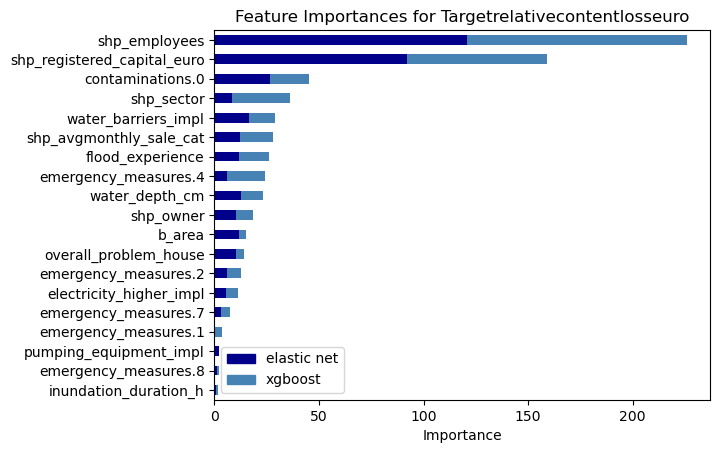

In [374]:
import matplotlib.patches as mpatches

# drop features which dont reduce the loss
# df_importance = df_importance.loc[df_importance.importances > 0.0000, : ] 
df_feature_importances = df_feature_importances.sort_values("overall_importances", ascending=True)

#fig, ax = plt.subplots(figsize=(12,5))
plt.figure(figsize=(8, 5))
#plt.barh(df_importance.name[-18:], df_importance.importances[-18:])
df_feature_importances[["en_importances_weighted", "xgb_importances_weighted"]].plot.barh(
    stacked=True, color=['darkblue', 'steelblue'],
    )
plt.xlabel("Importance")
plt.ylabel("")
# plt.xticks(rotation = 90)
plt.title(f"Feature Importances for {target.replace('_','')}")

# # Add a legend and informative axis label
# ax.legend(ncol=2, loc="lower right", frameon=True)
# ax.set(xlim=(0, 24), ylabel="",
#        xlabel="Automobile collisions per billion miles")

# ax.set_ylabel('percentage')
# Fix the legend so it's not on top of the bars.
# legend = ax.get_legend()
# legend.set_bbox_to_anchor((1, 1))

top_bar = mpatches.Patch(color="darkblue", label="elastic net")
bottom_bar = mpatches.Patch(color="steelblue", label="xgboost")
#bottom_bar = mpatches.Patch(color="lightblue", label="elastic net")
plt.legend(handles=[top_bar, bottom_bar])
plt.show()

#sns.despine(left=True, bottom=True)
## save importance scores and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)
#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')



In [119]:
# model #.best_estimator_#.cv_results
# #model_inner_cv

models_feature_importances.keys()#["logreg_feature_importance"]
models_feature_importances["logreg_feature_importance"]

model_feature_importances_ranking = pd.DataFrame(
    {
        #"logreg" : models_feature_importances["logreg_feature_importance"].index[0:10],
        "xgb" : models_feature_importances["xgb_feature_importance"].index[0:10],
        "en" : models_feature_importances["en_feature_importance"].index[0:10],
        #"crf" : models_feature_importances["crf_feature_importance"].index[0:10]
    }, 
    index=range(len(models_feature_importances["xgb_feature_importance"].index[0:10]))
)
model_feature_importances_ranking

,xgb,en
0,shp_employees,pumping_equipment_impl
1,shp_registered_capital_euro,flowvelocity
2,shp_sector,shp_avgmonthly_sale_cat
3,emergency_measures.7,hh_monthly_income_cat
4,contaminations.0,shp_registered_capital_euro
5,b_area,emergency_measures.3
6,protect_valuables_impl,water_depth_cm
7,electricity_higher_impl,protect_valuables_impl
8,hh_monthly_income_cat,contaminations.0
9,emergency_measures.2,emergency_measures.2


In [92]:
# models_trained["trained_logreg"].__init__

# # plotting cv results
# plt.figure(figsize=(16,6))

# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_test_score"])
# plt.plot(cv_results["param_n_features_to_select"], cv_results["mean_train_score"])
# plt.xlabel('number of features')
# plt.ylabel('r-squared')
# plt.title("Optimal Number of Features")
# plt.legend(['test score', 'train score'], loc='upper left')


In [103]:
# #print("penalty term: L1=lasso, L2= rigde : " , models_trained["trained_logreg_cv"].penalty)

# # cv results
# cv_results = pd.DataFrame( models_trained["trained_logreg_cv"].cv_results_)
# cv_results

models_trained#["trained_xgb_cv"]

{'trained_logreg_cv': Pipeline(steps=[('model',
                  LogisticRegression(C=8, l1_ratio=0.5, max_iter=4,
                                     penalty='elasticnet', random_state=42,
                                     solver='saga', tol=0.5))]),
 'trained_xgb_cv': Pipeline(steps=[('model',
                  XGBRegressor(base_score=None, booster='gblinear',
                               callbacks=None, colsample_bylevel=None,
                               colsample_bynode=None, colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=No

In [105]:
print("Testing models for : ", target)
e.empirical_vs_predicted(
    X, y,
    models_list = [models_trained["trained_logreg_cv"], models_trained["trained_xgb_cv"], models_trained["trained_en_cv"]] 
    #models_trained#[f"trained_{model_name}_cv"]
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO fix y empirical
# ## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


Testing models for :  Target_relative_contentloss_euro


,nobs,median,mean,min max,variance
0,110,0.011252,0.064507,"[0.0002538991165125394, 1.0]",4.45
1,110,1.000000,0.600000,"[0.0, 1.0]",-0.41
2,110,0.011252,0.064507,"[0.0002538991165125394, 1.0]",4.45
3,110,0.049998,0.062270,"[-0.05086763, 1.0296462]",7.58
4,110,0.011252,0.064507,"[0.0002538991165125394, 1.0]",4.45
5,110,0.064275,0.064507,"[0.04852103834647209, 0.10603273405987478]",1.45


In [107]:
# print(target)
# print(X.shape)

# df_importance

Target_relative_contentloss_euro
(133, 27)


,importances
shp_registered_capital_euro,0.156041
shp_employees,0.146143
contaminations.0,0.027468
water_barriers_impl,0.024416
flood_experience,0.024315
emergency_measures.4,0.023024
shp_sector,0.011757
b_area,0.010517
electricity_higher_impl,0.009988
bage,0.009262


In [75]:
print("median entire ds")
print(np.median(y))
print(np.median(model.predict(X)))

print("mean entire ds")
print(np.mean(y))
print(np.mean(model.predict(X)))



median entire ds
0.01000119482099409
0.04939702
mean entire ds
0.056081992063753514
0.060931973


## Empirical median ~ predicted median

And further statitics compared to their empirical counterpart.
-  mean /variance / std  compared to empirical distribution

In [85]:
print("XGB: ", target)
e.empirical_vs_predicted(
    X_test, y_test,
    models_list=[model, model_log, model_quantile, model_quantile, model_sqrt]    
    #models_list=[model, model_log, model_quantile, model_boxcox, model_sqrt]    
)

## TODO idea: make a median/mean etc of best model as boxplots 8one (3 models for each target)


XGB:  Target_relative_contentloss_euro


,nobs,median,mean,min max,variance
empirical,20,0.004890,0.022702,"[0.0002538991165125394, 0.1454527500740594]",2.04
no transform,20,0.020135,0.044268,"[0.0029349634, 0.35559636]",3.36
natural log,20,0.030449,0.062297,"[0.002778631, 0.33896157]",2.38
quantile,20,0.010037,0.012736,"[0.004311467, 0.044061705]",2.43
box-cox,20,0.010037,0.012736,"[0.004311467, 0.044061705]",2.43
sqrt,20,0.020135,0.044268,"[0.0029349634, 0.35559636]",3.36


In [14]:
import scipy.special as sc
#lam = -0.23
#inv_bc = ((np.sign(vector)*np.abs(vector) * lam) + 1) ** (1 / lam)


###  Transformation: Box-cox 
model_boxcox_pipe = Pipeline([
            ('model', TransformedTargetRegressor(regressor=XGBRegressor(),
                transformer=PowerTransformer(method="box-cox", standardize=False) # def=False:
                #transformer=PowerTransformer(method="yeo-johnson", standardize=False) # def=False
                #func=sc.boxcox(), inverse_func
                )
            )])
model_boxcox_cv = RandomizedSearchCV(
    estimator= model_boxcox_pipe,
    param_distributions=param_grid_transform,
    cv=cv, 
    scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
    refit=True,        
    random_state=seed
)
## Fit model with reciprocal-transformed target
model_boxcox_cv.fit(X_train, y_train)   
model_boxcox = model_boxcox_cv.best_estimator_


y_pred = model_boxcox.predict(X_test)
e.evaluation_report(y_test, y_pred)

## Note: Boxcox cant be used with nan values and also not with negativ or zero values

[02:36:04] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.



[02:36:04] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:05] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:05] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:05] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:05] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:05] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:05] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:05] WARNING: D:\bld\xgboost-split_1685694922754\work\src\learner.cc:767: 
Parameters: { "max_depth" } are not used.

[02:36:0

In [15]:
# importances = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame(
#     {"importances" : importances[0]},
#     index=X_train.columns.to_list(),
#     ) 
# df_importance = df_importance.sort_values("importances", ascending=False)  # get most important features to the top
# print("Most important features:", df_importance.iloc[:5].index.to_list())
# #df_importance = df_importance.loc[df_importance.importances >= 0.000000, : ]

# df_importance

In [16]:
model_cv.best_params_

y_train

##  MAE: + in target unit +  less likely to be affected by extreme values.
## MAPE: r (MAPE) quantifies the average absolute difference between 
## the anticipated and observed values of the target variable as a percentage of the observed value. 
## The method works well for assessing models where the target variable spans a broad range of scales

# 75 % in train mit 300 trress, subsam0.8, maxdep=3, aber bad teest R2


## R²-Score: 0.46
# {'model__validate_parameters': True,
#  'model__n_estimators': 800,
#  'model__max_depth': 10,
#  'model__eta': 0.2}


95      36.8
273    621.3
182    186.8
152     37.4
147    560.5
       ...  
185     44.7
275     39.7
40     644.3
234    382.7
268    223.4
Name: Target_contentloss_euro, Length: 132, dtype: float64

## Evaluation

In [17]:
## reload models

# fi_cols =  df_importance.loc[df_importance.importances >= 0.0000001 , : ].index.to_list()#.shape
# print(len(fi_cols))
# print(fi_cols)

# # model_cv = RandomizedSearchCV(
# #     estimator=XGBRegressor(), 
# #     param_distributions=param_grid, #
# #     #param_distributions=param_bag_grid, 
# #     cv=cv, 
# #     scoring= "neg_mean_absolute_error",##"neg_mean_absolute_error", #"neg_mean_squared_error",#"r2" ,#"neg_mean_absolute_error",   #TODO classifcation: test also e.g "f1" or recall or "f1_micro", "neg_mean_absolute_error",
# #     refit=False,   ## Refit the best estimator with the entire dataset. If “False”, it is impossible to make predictions using this GridSearchCV instance after fitting.
# #                     ## If refit=False, clf.fit() will have no effect because the GridSearchCV object inside the pipeline will be reinitialized after fit().
# #                     ## ! When refit=True, the GridSearchCV will be refitted with the best scoring parameter combination on the whole data that is passed in fit()
# #     random_state=seed
# # )
# # Fit model
# #model =XGBRegressor()# model_cv.best_estimator_
# model.fit(X_train.loc[:, fi_cols], y_train)   

# #print('Train R^2 Score : %.3f'%model_cv.best_estimator_.score(X_train.loc[:, fi_cols], y_train))
# #print('Test R^2 Score : %.3f'%model_cv.best_estimator_.score(X_test.loc[:, fi_cols], y_test))
# #print("CV score: ", model_cv.best_score_ ,  model_cv.best_estimator_.score(X_train, y_train),  model_cv.best_estimator_.score(X_test, y_test))
# ## Evaluate
# ## print evaluation report + check for overfitting 
# print("\nTraining set")
# y_pred_train = model.predict(X_train.loc[:, fi_cols])
# #y_pred_train = model_cv.best_estimator_.predict(X_train)
# e.evaluation_report(y_train, y_pred_train)

# print("\nTesting set")
# #y_pred = model_cv.best_estimator_.predict(X_test)
# y_pred = model.predict(X_test.loc[:, fi_cols])
# e.evaluation_report(y_test, y_pred)


In [18]:


##pipelines = ["pipe_bag_en"]#, 
pipelines = ["pipe_en" ]#
pipe_name = pipelines[0]

#model_eval = pickle.load(open(f"./models_trained/best_elasticnet_{target}_{pipe_name}.sav", 'rb'))
#elastic_net_eval.get_params()



In [19]:
print('R^2 training set', round(model.score(X_train, y_train)*100, 2), ' %')
print('R^2 test set', round(model.score(X_test, y_test)*100, 2))

learning_rate = [0.001, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]



## Plot tagret vs its log-transformed version

## Plot tagret vs its log-transformed version

R^2 training set 97.9  %
R^2 test set -49.21


In [20]:
## Plot learning rate see if    
means = model_cv.cv_results_['mean_test_score']
stds = model_cv.cv_results_['std_test_score']
params = model_cv.cv_results_['params']

# for mean, stdev, param in zip(means, stds, params):
#     print("%f (%f) with: %r" % (mean, stdev, param))

# plot results
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# for mean, stdev, param in zip(means, stds, params):
# 	print("%f (%f) with: %r" % (mean, stdev, param))
# plot
#plt.use('Agg')
import matplotlib
matplotlib.use('Agg')


plt.errorbar(learning_rate, means, yerr=stds)
plt.legend()
plt.xlabel('learning_rate')
plt.ylabel('Log Loss')
plt.savefig('log_loss_vs_learning_rate.png')
plt.show()
# scores = np.array(means).reshape(len(learning_rate), len(n_estimators))
# for i, value in enumerate(learning_rate):
#     plt.plot(n_estimators, scores[i], label='learning_rate: ' + str(value))
# plt.legend()
# plt.xlabel('learning_rate')
# plt.ylabel('Log Loss')
# plt.savefig('n_estimators_vs_learning_rate.png')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [21]:
#plt.savefig(f"./models_trained/FI_{target}.png", bbox_inches='tight')
#sns_plot.figure.savefig("output.png")
print(model.score(X_train, y_train))
print(model.score(X_test, y_test))


0.9790346135872993
-0.4921255591097222


### Plot prediction error 

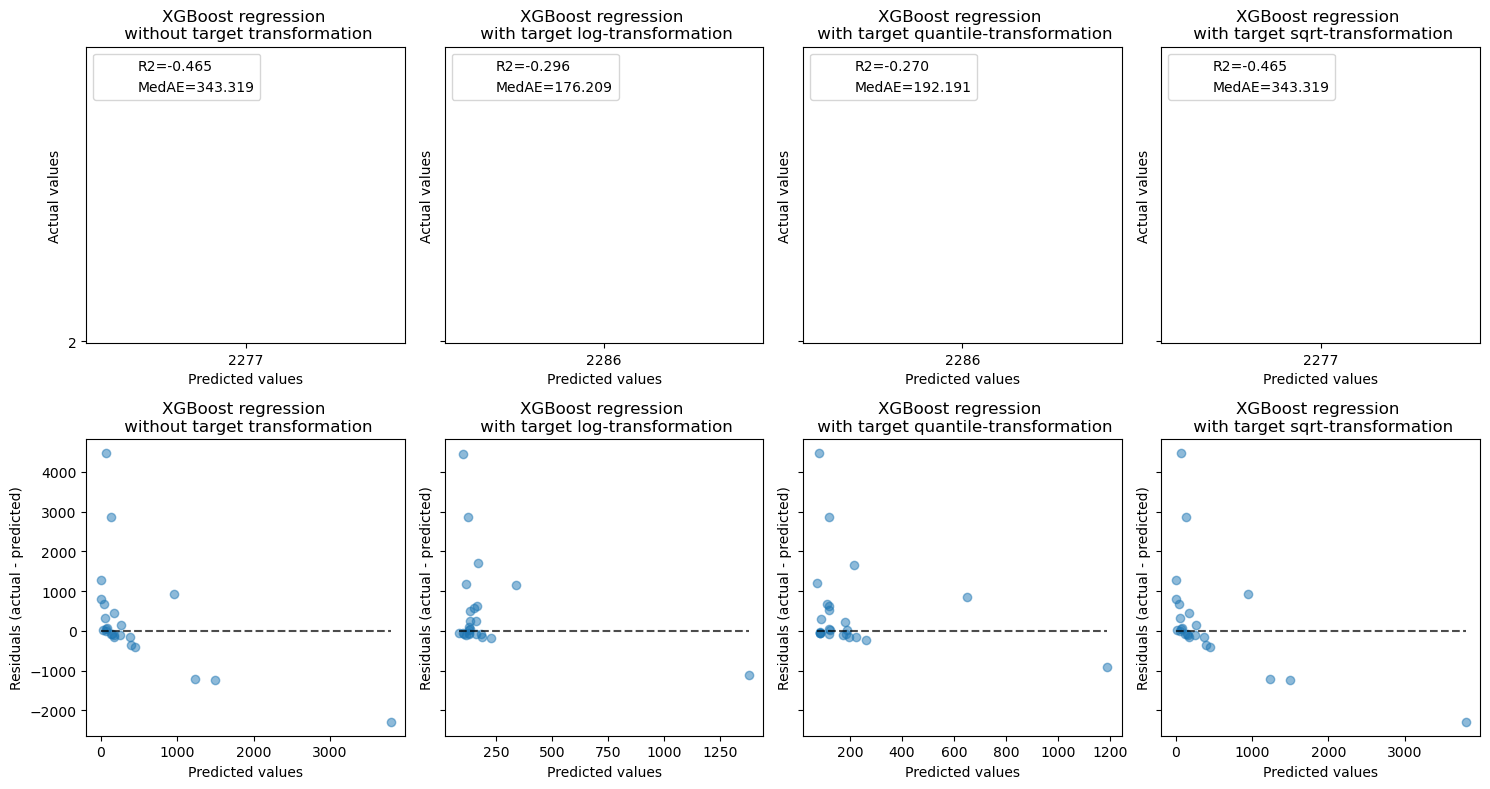

In [63]:
#y_pred_log_train = model_log.predict(X_train)
y_pred = model.predict(X_test)
y_pred_log = model_log.predict(X_test)
y_pred_quantile = model_quantile.predict(X_test)
#y_pred_boxcox = model_boxcox.predict(X_test)
y_pred_sqrt = model_sqrt.predict(X_test)


f, (ax0, ax1) = plt.subplots( 2, 4,  sharey="row", figsize=(15, 8)) # 

PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="actual_vs_predicted",
    ax=ax0[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="actual_vs_predicted",
    ax=ax0[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="actual_vs_predicted",
    ax=ax0[2],
    scatter_kwargs={"alpha": 0.5},
)
# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_boxcox,
#     kind="actual_vs_predicted",
#     ax=ax0[3],
#     scatter_kwargs={"alpha": 0.5},
# )
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_sqrt,
    kind="actual_vs_predicted",
    ax=ax0[3],
    scatter_kwargs={"alpha": 0.5},
)
ax0[0].set_title("XGBoost regression \n without target transformation")
ax0[1].set_title("XGBoost regression \n with target log-transformation")
ax0[2].set_title("XGBoost regression \n with target quantile-transformation")
ax0[3].set_title("XGBoost regression \n with target sqrt-transformation")
#ax0[3].set_title("XGBoost regression \n with target boxcox-transformation")

ax0[0].set_ylim(0, 300)


# Add the score in the legend of each axis
for ax, y_pred in zip([ax0[0], ax0[1], ax0[2],ax0[3]], [y_pred, y_pred_log, y_pred_quantile, y_pred_sqrt]):
#for ax, y_pred in zip([ax0[0], ax0[1], ax0[2],ax0[3]], [y_pred, y_pred_log, y_pred_quantile, y_pred_boxcox]):
    for name, score in e.compute_score(y_test, y_pred).items():
        ax.plot([], [], " ", label=f"{name}={score}")
    ax.legend(loc="upper left")


# plot the residuals vs the predicted values
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred,
    kind="residual_vs_predicted",
    ax=ax1[0],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_log,
    kind="residual_vs_predicted",
    ax=ax1[1],
    scatter_kwargs={"alpha": 0.5},
)
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_quantile,
    kind="residual_vs_predicted",
    ax=ax1[2],
    scatter_kwargs={"alpha": 0.5},
)
# PredictionErrorDisplay.from_predictions(
#     y_test,
#     y_pred_boxcox,
#     kind="residual_vs_predicted",
#     ax=ax1[3],
#     scatter_kwargs={"alpha": 0.5},
# )
PredictionErrorDisplay.from_predictions(
    y_test,
    y_pred_sqrt,
    kind="residual_vs_predicted",
    ax=ax1[3],
    scatter_kwargs={"alpha": 0.5},
)
ax1[0].set_title("XGBoost regression \n without target transformation")
ax1[1].set_title("XGBoost regression \n with target log-transformation")
ax1[2].set_title("XGBoost regression \n with target quantile-transformation")
#ax1[3].set_title("XGBoost regression \n with target boxcox-transformation")
ax1[3].set_title("XGBoost regression \n with target sqrt-transformation")

#ax1[0].set_ylim(0,200)


#f.suptitle("Synthetic data", y=1.05)
plt.tight_layout()


## reload models


#model_eval = pickle.load(open(f"./models_trained/xgboost_{target}_{pipe_name}.sav", 'rb'))
#model_eval.get_params()
#dir(model_eval)#.feature_importances_[model_eval.feature_importances_>0.015].shape

## Feature importance
Have the same feature importance method across all applied ML models


In [24]:

# df_importance_package = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : model.feature_importances_,
#      }) 
# df_importance_package.sort_values("importances", ascending=False)[:10]

In [25]:
# ## Permuation feature importance
# result = e.permutation_feature_importance(model, X_test, y_test, repeats=5, seed=seed)

# df_importance = pd.DataFrame({
#     "name" : X_train.columns.to_list(),
#     "importances" : result[0],
# #    "importances" : np.abs(result[0]),
#      }) 
# df_importance = df_importance.sort_values("importances", ascending=True)  # get most important features to the top
# df_importance.tail(18)

### plot feature importance


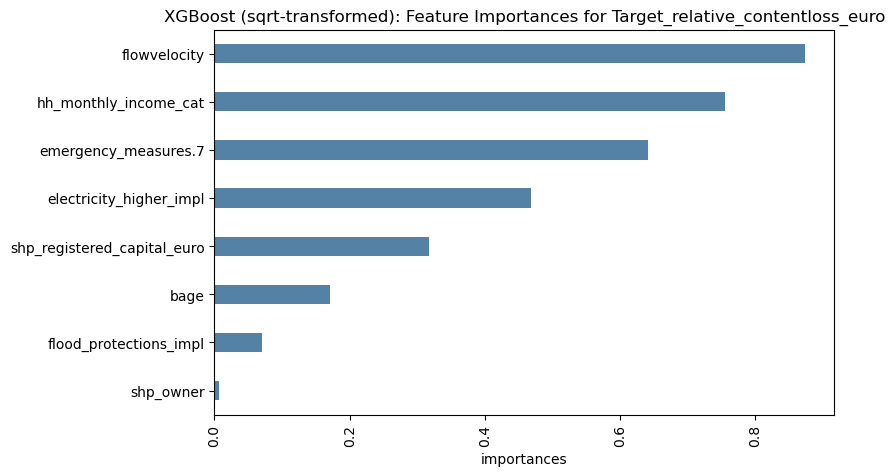

In [86]:
# reload evalation set
eval_set = eval_set_list[0]#[pipe_name]


importances = e.permutation_feature_importance(model_sqrt, 
#importances = e.permutation_feature_importance(model, 
                                               X_test,
                                               y_test,
                                               #eval_set.drop(target, axis=1), 
                                               #eval_set[target], 
                                               repeats=5, seed=seed
                                               )

## feature importance scores
df_importance = pd.DataFrame({
    "name" : X_unscaled.columns.to_list(),
    "importances" : importances[0],
     }) 

# drop features which dont reduce the loss
df_importance = df_importance.loc[df_importance.importances > 0.0000, : ] 
df_importance = df_importance.sort_values("importances", ascending=False)


#fig, ax = plt.subplots(figsize=(12,5))
plt.figure(figsize=(8, 5))
#plt.barh(df_importance.name, df_importance.importances)
#plt.barh(df_importance.name[-18:], df_importance.importances[-18:])

sns.barplot(
    data=df_importance, 
    x="importances", y="name",
    width=0.4,
    color='steelblue',
    #errorbar="sd",
    errorbar=("pi", 50), 
    capsize=.1, errcolor=".5",
    linewidth=3, #edgecolor=".3", #facecolor=(0,0,0,0),
)
plt.ylabel("")
plt.xticks(
    rotation = 90
    )
plt.title(f"XGBoost (sqrt-transformed): Feature Importances for {target}")
plt.show()

## save importnace scores  and figure
#filepath = f'./models_evaluation/best_xgb_importance_scores_{target}_{pipe_name}'
#if not glob(filepath):
#    df_importance.to_csv(filename, index = False)


#plt.savefig(f'../../../figures/best_en_feature_importance_{target}_{pipe_name}.png', bbox_inches='tight')





## left overs

##### Hierarchical clustering on Spearman rank correlation

Select only feautres with low collienarity to solve disadvantage of perumation feature importance.
Randomizing one feature would lead to only small importance score - the model performance wouldnt be move influenced - due that the information is included in other correlated features. Removing one feature keeps the similar inforamtion in the other feautres unchanged and the model learns from the correlated feature. Therefore apply hierachical clustering to select less correlated features

See also:
- Brill 2020 (dissertation)
- https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html # code example

In [ ]:
# import scipy.cluster.hierarchy as shc

# plt.figure(figsize=(15, 10))
# plt.title("Customers Dendrogram")

# # Selecting Annual Income and Spending Scores by index
# selected_data = X_train.dropna()
# selected_data = selected_data.T # only possible with out nan
# clusters = shc.linkage(selected_data, 
#             method='ward', optimal_ordering=False,
#             metric="euclidean")
# shc.dendrogram(Z=clusters, 
#                #p=20, # p -> value for truncation mode
#                orientation="right",
#                labels=X_train.columns
#                ) 
# plt.show()

# ## TODO adapt with spearman rank order



In [ ]:

# from scipy.stats import spearmanr
# from scipy.spatial.distance import squareform
# from scipy.cluster.hierarchy import ward, dendrogram

# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
# corr = spearmanr(X_unscaled_no_nan).correlation

# # Ensure the correlation matrix is symmetric
# corr = (corr + corr.T) / 2
# np.fill_diagonal(corr, 1)

# # We convert the correlation matrix to a distance matrix before performing
# # hierarchical clustering using Ward's linkage.
# distance_matrix = 1 - np.abs(corr)
# dist_linkage = ward(distance_matrix, checks=False )
# dendro = dendrogram(
#     dist_linkage, labels=X_unscaled_no_nan.columns.tolist(), ax=ax1, leaf_rotation=90
# )
# dendro_idx = np.arange(0, len(dendro["ivl"]))

# ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
# ax2.set_xticks(dendro_idx)
# ax2.set_yticks(dendro_idx)
# ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
# ax2.set_yticklabels(dendro["ivl"])
# fig.tight_layout()

# cluster_ids = shc.fcluster(dist_linkage, 1, criterion="distance")
# cluster_id_to_feature_ids = defaultdict(list)
# for idx, cluster_id in enumerate(cluster_ids):
#     cluster_id_to_feature_ids[cluster_id].append(idx)
# selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

# X_train_sel = X_train[:, selected_features]
# X_test_sel = X_test[:, selected_features]



In [ ]:
# closs hyperapram , no model__early_stopping_rounds, repeatedcv wit h10 folds
## best train R2: ntree=30, max_depth =1, no furhter params

# learning_rate = [ 0.00001, 0.0001, 0.001, 0.1, 0.2]#, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9] # store outside, for plotting
# n_estimators = [ 50, 100, 200, 300, 500, 800]

# param_grid = {'model__n_estimators': n_estimators,
#     #'model__n_estimators': [ 3, 5, 10, 20], # get only low train scores with this
#               'model__max_depth': [1, 2, 3, 5, 7, 8, 10, 15],
#               #'model__max_leaves': [0, 3, 5],
#              # 'model__colsample_bytree': [ 0.3, 0.5, 0.7, 1.0 ], # Percentage of columns to be randomly samples for each tree
#              # 'model__colsample_bynode': [ 0.3, 0.5, 0.7, 1.0], # nbr of feautres for each split point
#              # 'model__eta': learning_rate,  # == eta
#             #   'model__gamma': [0.2, 0.3, 0.5, 0.8, 1, 3] , # min_split_loss -  larger gamma is, the more conservative the algorithm is
#               'model__subsample': [0.0, 0.2, 0.5, 0.6, 0.8, 0.9],  # define subsample of train st prior to growing trees, prevent overfitting
#             #  'model__reg_alpha': [0.5, 1.0, 2.0, 4.0, 5.0, 6.0 ,7.0],   # Lasso Regularization term on weights , higher values = more consrvative 
#             #  'model__reg_lambda': [0.0, 0.1, 0.5, 1.0, 2.0, 3.0, 4.0, 5.0],  # Ridge Regularization term on weights ,  higher values = more consrvative
#             #   'model__min_child_weight': [0, 1, 2, 3, 4,],
#             #   "model__max_delta_step":  [0, 3, 5, 6, 7],           # for LogisticReg good to solve imbalance 
#           #   'model__objective': [None, 'reg:absoluteerror'],#'multi:softprob,'reg:squarederror','reg:models_trained'],
#           #  # 'model__tree_method': ["hist", "gpu_hist"],
#           #   'model__booster': [None, "gblinear", "gbtree"],
#             "model__validate_parameters":[True],
#               }

# # 'model__scale_pos_weight': [0.0, 0.3, 0.5, 0.7, 0.9, 1.0],  # only  for clasifcation: handle imbalance, ratio between negative and positive examples

# # Objective candidate: multi:softmax
# # Objective candidate: multi:softprob
# # Objective candidate: reg:squarederror
# # Objective candidate: reg:squaredlogerror
# # Objective candidate: reg:logistic
# ## Objective candidate: reg:linear
# # Objective candidate: reg:pseudohubererror
# # Objective candidate: reg:gamma
# # Objective candidate: reg:absoluteerror

# ## DOC: https://xgboost.readthedocs.io/en/stable/parameter.html
